In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [51]:
df = pd.read_csv("data/heart.csv")
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [52]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [53]:
# Replace categorical values with numerical values
# Sex
# M = 1, F = 0
df['Sex'].replace(['M', 'F'], [1, 0], inplace=True)

# TODO: Abstract this to a function

# ChestPainType
# Assign value by index
chest_pain_types = df["ChestPainType"].unique()
df["ChestPainType"].replace(chest_pain_types, [i for i in range(len(chest_pain_types))], inplace=True)

# RestingECG
# Assign value by index
resting_ecgs = df["RestingECG"].unique()
df["RestingECG"].replace(resting_ecgs, [i for i in range(len(resting_ecgs))], inplace=True)

# ExerciseAngina
# Y = 1, N = 0
df['ExerciseAngina'].replace(['Y', 'N'], [1, 0], inplace=True)

# ST_Slope
# Assign value by index
st_slopes = df["ST_Slope"].unique()
print(st_slopes)
df["ST_Slope"].replace(st_slopes, [i for i in range(len(st_slopes))], inplace=True)

# Normalize Oldpeak values between 0 and 1
min_oldpeak = df["Oldpeak"].min()
max_oldpeak = df["Oldpeak"].max()
oldpeaks = df["Oldpeak"]
normalized_oldpeaks = oldpeaks.copy()
for i in range(len(oldpeaks)):
    normalized_oldpeaks[i] -= min_oldpeak
for i in range(len(oldpeaks)):
    normalized_oldpeaks[i] /= (max_oldpeak - min_oldpeak)

df["Oldpeak"] = normalized_oldpeaks


['Up' 'Flat' 'Down']


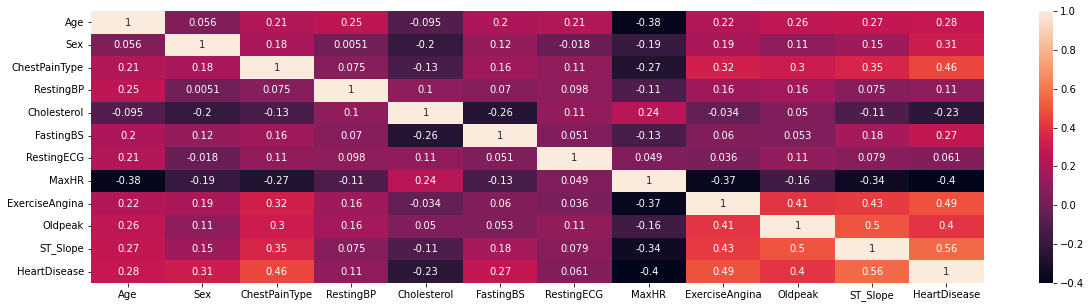

In [54]:
plt.figure(figsize = (20,5))
sns.heatmap(df.corr(),annot = True);

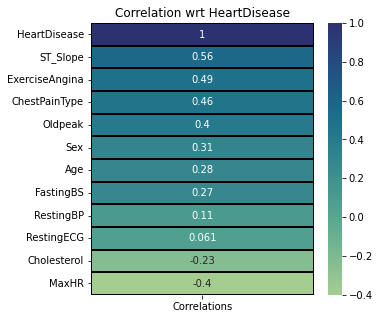

In [55]:
corr = df.corrwith(df['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,linewidths = 0.4,linecolor = 'black', cmap="crest");
plt.title('Correlation wrt HeartDisease');

In [56]:
# Model Features
X = df[["MaxHR", "Cholesterol", "FastingBS", "Age", "Sex", "Oldpeak", "ChestPainType", "ExerciseAngina", "ST_Slope"]]  # strongly correlated features
Y = df[['HeartDisease']]  # the target output

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=100)


In [57]:
def model(classifier):
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    return prediction

In [58]:
def evaluate_model(classifier, X_test, X_train, y_test, y_pred):
    # Evaluate the Model's Performance
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
    print('Recall: ', metrics.recall_score(y_test, y_pred, zero_division=1))
    print("Precision:", metrics.precision_score(y_test, y_pred, zero_division=1))
    print("CL Report:", metrics.classification_report(y_test, y_pred, zero_division=1))
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, cmap="crest", annot = labels, fmt ='')
    plt.show()
    # TODO: ROC Curve
    # cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    # print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,X_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    # print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test, y_pred)))
    # plot_roc_curve(classifier, X_test, y_test)
    # plt.title('ROC_AUC_Plot')
    # plt.show()

c:\Users\Eli PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Eli PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.8777173913043478
Recall:  0.9014778325123153
Precision: 0.8798076923076923
CL Report:               precision    recall  f1-score   support

           0       0.88      0.85      0.86       165
           1       0.88      0.90      0.89       203

    accuracy                           0.88       368
   macro avg       0.88      0.87      0.88       368
weighted avg       0.88      0.88      0.88       368



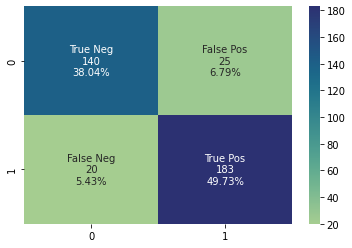

In [59]:
from sklearn.linear_model import LogisticRegression
# Create a logistic regression body
classifier_logreg = LogisticRegression(random_state = 0, C=10, penalty= 'l2')
y_pred = model(classifier_logreg)
evaluate_model(classifier_logreg, X_test, X_train, y_test, y_pred)


In [60]:
# Create new data to predict
print(X_train.head(5))
x1 = pd.DataFrame([{"MaxHR": 170, "Cholesterol": 237, "FastingBS": 0, "Age": 45, "Sex": 1, "Oldpeak": 0, "ChestPainType": 0, "ExerciseAngina": 0, "ST_Slope": 0}])
y1 = classifier_logreg.predict(x1)
print(y1)

x2 = pd.DataFrame([{"MaxHR": 118, "Cholesterol": 180, "FastingBS": 1, "Age": 60, "Sex": 0, "Oldpeak": 0.5, "ChestPainType": 2, "ExerciseAngina": 1, "ST_Slope": 0}])
y2 = classifier_logreg.predict(x2)
print(y2)

     MaxHR  Cholesterol  FastingBS  Age  Sex   Oldpeak  ChestPainType  \
271    165          198          0   32    0  0.295455              0   
670    168          198          0   41    0  0.295455              0   
422    105          236          1   65    1  0.295455              2   
290    138          211          0   48    1  0.295455              1   
140     94          331          0   52    1  0.579545              2   

     ExerciseAngina  ST_Slope  
271               0         0  
670               0         0  
422               1         1  
290               0         0  
140               1         1  
[0]
[1]


c:\Users\Eli PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.8695652173913043
Recall:  0.8916256157635468
Precision: 0.8743961352657005
CL Report:               precision    recall  f1-score   support

           0       0.86      0.84      0.85       165
           1       0.87      0.89      0.88       203

    accuracy                           0.87       368
   macro avg       0.87      0.87      0.87       368
weighted avg       0.87      0.87      0.87       368



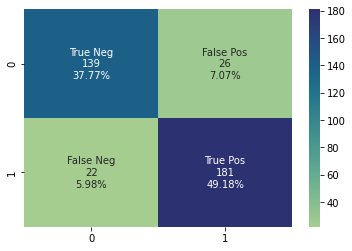

In [61]:
from sklearn.svm import SVC
classifier_svc = SVC(kernel = 'linear',C = 0.1)
y_pred = model(classifier_svc)
evaluate_model(classifier_svc, X_test, X_train, y_test, y_pred)

Accuracy:  0.8369565217391305
Recall:  0.8768472906403941
Precision: 0.8356807511737089
CL Report:               precision    recall  f1-score   support

           0       0.84      0.79      0.81       165
           1       0.84      0.88      0.86       203

    accuracy                           0.84       368
   macro avg       0.84      0.83      0.83       368
weighted avg       0.84      0.84      0.84       368



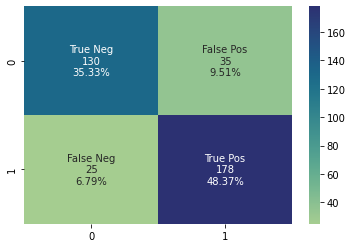

In [62]:
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)
y_pred = model(classifier_dt)
evaluate_model(classifier_dt, X_test, X_train, y_test, y_pred)

C:\Users\ELIPC~1\AppData\Local\Temp/ipykernel_13056/1391133278.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


Accuracy:  0.8722826086956522
Recall:  0.9064039408866995
Precision: 0.8679245283018868
CL Report:               precision    recall  f1-score   support

           0       0.88      0.83      0.85       165
           1       0.87      0.91      0.89       203

    accuracy                           0.87       368
   macro avg       0.87      0.87      0.87       368
weighted avg       0.87      0.87      0.87       368



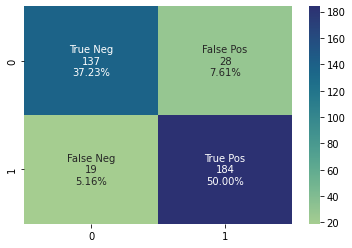

In [63]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)
y_pred = model(classifier_rf)
evaluate_model(classifier_rf, X_test, X_train, y_test, y_pred)

c:\Users\Eli PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy:  0.717391304347826
Recall:  0.7536945812807881
Precision: 0.7391304347826086
CL Report:               precision    recall  f1-score   support

           0       0.69      0.67      0.68       165
           1       0.74      0.75      0.75       203

    accuracy                           0.72       368
   macro avg       0.71      0.71      0.71       368
weighted avg       0.72      0.72      0.72       368



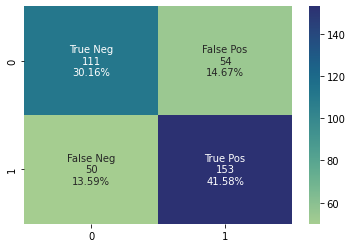

In [64]:
from sklearn.neighbors import KNeighborsClassifier
classifier_knn = KNeighborsClassifier(leaf_size = 1, n_neighbors = 3,p = 1)
y_pred = model(classifier_knn)
evaluate_model(classifier_knn, X_test, X_train, y_test, y_pred)